1. Install Dependencies and Bring in Data

In [ ]:
#!pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/LSTM - Comment toxicity/train.csv')

In [ ]:
df[df['toxic']==1]

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
6,0002bcb3da6cb337,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1,1,1,0,1,0
12,0005c987bdfc9d4b,Hey... what is it..\n@ | talk .\nWhat is it......,1,0,0,0,0,0
16,0007e25b2121310b,"Bye! \n\nDon't look, come or think of comming ...",1,0,0,0,0,0
42,001810bf8c45bf5f,You are gay or antisemmitian? \n\nArchangel WH...,1,0,1,0,1,1
43,00190820581d90ce,"FUCK YOUR FILTHY MOTHER IN THE ASS, DRY!",1,0,1,0,1,0
...,...,...,...,...,...,...,...,...
159494,fef4cf7ba0012866,"""\n\n our previous conversation \n\nyou fuckin...",1,0,1,0,1,1
159514,ff39a2895fc3b40e,YOU ARE A MISCHIEVIOUS PUBIC HAIR,1,0,0,0,1,0
159541,ffa33d3122b599d6,Your absurd edits \n\nYour absurd edits on gre...,1,0,1,0,1,0
159546,ffb47123b2d82762,"""\n\nHey listen don't you ever!!!! Delete my e...",1,0,0,0,1,0


In [ ]:
df.iloc[15]['comment_text']

'"\n\nJuelz Santanas Age\n\nIn 2002, Juelz Santana was 18 years old, then came February 18th, which makes Juelz turn 19 making songs with The Diplomats. The third neff to be signed to Cam\'s label under Roc A Fella. In 2003, he was 20 years old coming out with his own singles ""Santana\'s Town"" and ""Down"". So yes, he is born in 1983. He really is, how could he be older then Lloyd Banks? And how could he be 22 when his birthday passed? The homie neff is 23 years old. 1983 - 2006 (Juelz death, god forbid if your thinking about that) equals 23. Go to your caculator and stop changing his year of birth. My god."'

In [ ]:
df[df.columns[2:]].iloc[15]

toxic            0
severe_toxic     0
obscene          0
threat           0
insult           0
identity_hate    0
Name: 15, dtype: int64

2. Preprocessing

In [ ]:
!pip list

Package                       Version
----------------------------- ----------------------
absl-py                       1.4.0
aeppl                         0.0.33
aesara                        2.7.9
aiofiles                      23.1.0
aiohttp                       3.8.4
aiosignal                     1.3.1
alabaster                     0.7.13
albumentations                1.2.1
altair                        4.2.2
anyio                         3.6.2
appdirs                       1.4.4
argon2-cffi                   21.3.0
argon2-cffi-bindings          21.2.0
arviz                         0.12.1
astor                         0.8.1
astropy                       4.3.1
astunparse                    1.6.3
async-timeout                 4.0.2
atari-py                      0.2.9
atomicwrites                  1.4.1
attrs                         22.2.0
audioread                     3.0.0
autograd                      1.5
Babel                         2.11.0
backcall                      0.2.0
bea

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
X = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
y

array([[0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       ...,
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocabulary

In [ ]:
vectorizer = TextVectorization(max_tokens=MAX_FEATURES,
                               output_sequence_length=1800,
                               output_mode='int') # max sentence length=1800, words mapped to int

In [ ]:
vectorizer.adapt(X.values) # learn vocabulary

In [ ]:
vectorizer('Hello, how are you')[:4]

<tf.Tensor: shape=(4,), dtype=int64, numpy=array([288,  73,  20,   7])>

In [ ]:
vectorized_text = vectorizer(X.values) # tokenize

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [ ]:
batch_X, batch_y = dataset.as_numpy_iterator().next()

In [ ]:
train = dataset.take(int(len(dataset)*.7)) # 70% of all data for training
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2)) # 20% for validation
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1)) # 10% for testing

In [ ]:
train_generator = train.as_numpy_iterator()

In [ ]:
train_generator.next()

(array([[   5,   85,    8, ...,    0,    0,    0],
        [  11,  159,    8, ...,    0,    0,    0],
        [  10,  329,  524, ...,    0,    0,    0],
        ...,
        [ 218,   67,   51, ...,    0,    0,    0],
        [  70,   15,  262, ...,    0,    0,    0],
        [ 414, 9548,   74, ...,    0,    0,    0]]), array([[1, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [1, 0, 1, 0, 1, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

2. Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential 
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Bidirectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extracting FC layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# Final layer
model.add(Dense(6, activation='sigmoid')) # sigmoid outputs values between 0 and 1

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 32)          6400032   
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               16640     
 nal)                                                            
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dense_5 (Dense)             (None, 256)               33024     
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 6)                 774       
                                                      

In [ ]:
history = model.fit(train, epochs=10, validation_data=val) # training

Epoch 1/10
6981/6981 [==============================] - 738s 103ms/step - loss: 0.0626 - val_loss: 0.0499
Epoch 2/10
6981/6981 [==============================] - 641s 92ms/step - loss: 0.0463 - val_loss: 0.0416
Epoch 3/10
6981/6981 [==============================] - 636s 91ms/step - loss: 0.0407 - val_loss: 0.0365
Epoch 4/10
6981/6981 [==============================] - 635s 91ms/step - loss: 0.0364 - val_loss: 0.0308
Epoch 5/10
6981/6981 [==============================] - 629s 90ms/step - loss: 0.0329 - val_loss: 0.0275
Epoch 6/10
6981/6981 [==============================] - 627s 90ms/step - loss: 0.0291 - val_loss: 0.0257
Epoch 7/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0266 - val_loss: 0.0233
Epoch 8/10
6981/6981 [==============================] - 638s 91ms/step - loss: 0.0240 - val_loss: 0.0203
Epoch 9/10
6981/6981 [==============================] - 624s 89ms/step - loss: 0.0217 - val_loss: 0.0181
Epoch 10/10
6981/6981 [==============================]

In [ ]:
import matplotlib.pyplot as plt

<Figure size 576x360 with 0 Axes>

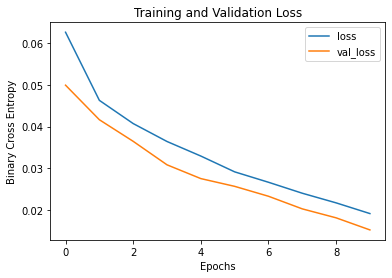

In [ ]:
plt.figure(figsize=(8,5))
pd.DataFrame(history.history).plot()
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Binary Cross Entropy')
plt.show()

3. Make Predictions

In [ ]:
input_text = vectorizer('You are stupid!')

In [ ]:
batch_X, batch_y = test.as_numpy_iterator().next()

In [ ]:
batch_y

array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 1, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
(model.predict(batch_X) > 0.5).astype(int)

1/1 [==============================] - 1s 918ms/step


array([[1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 1],
       [0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0]])

In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
model.predict(np.expand_dims(input_text, 0))

1/1 [==============================] - 0s 62ms/step


array([[0.9975682 , 0.17269304, 0.97813296, 0.00360033, 0.8606656 ,
        0.01563448]], dtype=float32)

4. Evaluate Model

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
precision = Precision()
recall = Recall()
accuracy = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  # Unpack the batch
  X_true, y_true = batch
  # Make a prediction
  y_pred = model.predict(X_true)

  # Flatten
  y_true = y_true.flatten()
  y_pred = y_pred.flatten()

  precision.update_state(y_true, y_pred)
  recall.update_state(y_true, y_pred)
  accuracy.update_state(y_true, y_pred)

1/1 [==============================] - 0s 76ms/step


In [ ]:
print(f'Precision: {precision.result().numpy()}, Recall: {recall.result().numpy()}, Accuracy: {accuracy.result().numpy()}')

Precision: 0.9146985411643982, Recall: 0.9162259697914124, Accuracy: 0.5135406255722046


5. Testing and Gradio App

In [ ]:
#!pip install gradio jinja2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import gradio as gr

ModuleNotFoundError: ignored

In [ ]:
model.save('Toxicity.h5')

In [ ]:
model = tf.keras.models.load_model('Toxicity.h5')

NameError: ignored

In [ ]:
input_str = vectorizer('I\'m coming for you! You piece of shit!')

In [ ]:
rez = model.predict(np.expand_dims(input_str, 0))

1/1 [==============================] - 1s 1s/step


In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
rez

array([[0.96145487, 0.07846484, 0.8350878 , 0.00443802, 0.27942246,
        0.00215265]], dtype=float32)

In [ ]:
def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

In [ ]:
interface = gr.Interface(fn=score_comment,
                         inputs=gr.inputs.Textbox(lines=2, placeholder='Comment to score'),
                         outputs='text')

/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)


In [ ]:
interface.launch(share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://6f5c7d29b0d010e864.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces
